How Accurate are Polls? An Analysis of Senate Election Polling Data

By William Meagher
Published 5/16/22

Table of Contents:
1. Introduction
2. Data Collection
    1. Polling Data
    2. Restults Data
    3. Merging
3. Exploratory Data Analysis and Hypothesis Testing
    1. Analysis By Party
    2. Sponsored vs Unsponsored
    3. Pollster Rating
    4. Poll Sample Size
    5. Election Stage
    6. By Percentage Predicted
4. Conclusion

1. Introduction


Polling data is 
Election polling is relied on by many voters and politicians when determining the state of the upcoming election. This data may be used by votes to decide whether or not they want to vote and by politicians to determine where to allocate their resources. But are the polls that people put their faith in to gain an understanding of the upcoming election really accurate? In this project, I will examine data from senate polling and comparing it to the actual election results in an attempt to gain insights. FiveThirtyEight is one of the most trusted sources of polling data

I chose fivethirtyeight as my source for polls because it is the source that I typically use when I look at polling data so I was curious to examine the accuracy of the data on the site.

Links
fivethirtyeight polls policy and faqs https://fivethirtyeight.com/features/polls-policy-and-faqs/
fivethirtyeight pollster ratings https://projects.fivethirtyeight.com/pollster-ratings/
page where the results data was sourced https://dataverse.harvard.edu/file.xhtml?fileId=4300300&version=5.0


In [2]:
# import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import urllib.request
import scipy.stats as stats
from operator import itemgetter
from io import StringIO

2.1 Polling Data

We start by retreiving polling data for senate elections from fivethirtyeight. The data that is being pulled is from 2018-2021.

In [3]:
# retreieve polling data from fivethirtyeight
POLLS_URL = "https://projects.fivethirtyeight.com/polls/data/senate_polls_historical.csv"
polling_data = pd.read_csv(POLLS_URL)

Next we need to clean up the data a little bit so it is easier to use. Since the polling data does not include the actual result of the election it will need to be merged with a table containing the actual results of the election in order to gauge the accuracy of the polling data.

In [4]:
# get just the fields we need from the polling data
polling_data = polling_data.filter(items=['pollster', 'pollster_rating_id', 'fte_grade', 'methodology', 'state', 'stage', 'start_date', 'end_date', 'sample_size', 'partisan', 'election_date', 'party', 'candidate_name', 'pct'])

In [5]:
# convert dates to dtaetimes
polling_data['end_date'] = pd.to_datetime(polling_data['end_date'], format="%m/%d/%y")
polling_data['start_date'] = pd.to_datetime(polling_data['start_date'], format="%m/%d/%y")
polling_data['election_date'] = pd.to_datetime(polling_data['election_date'], format="%m/%d/%y")

# get year of election so data can be merged with actual election results
polling_data['year'] = pd.DatetimeIndex(polling_data['election_date']).year

# get the days until the election when the poll was completed
polling_data['until_election'] = (polling_data.election_date - polling_data.end_date).dt.days

# map our party to a full party name so it can be joined with results data
party_map = {
    'DEM': 'DEMOCRAT',
    'REP': 'REPUBLICAN',
}
polling_data['party'] = polling_data['party'].map(lambda x: party_map.get(x, 'OTHER'))

# uppercase state and stage for joining purposes
polling_data['state'] = polling_data['state'].str.upper()
polling_data['stage'] = polling_data['stage'].str.upper()

# get just last name of candiate and set it as candiate_last
polling_data['candidate_name'] = polling_data['candidate_name'].str.split().apply(itemgetter(-1)).str.upper()
polling_data = polling_data.rename(columns = {'candidate_name':'candidate_last'})

2.2 Election Results

We now will retreive and clean up the data for the results of the elections for which we have polling data

In [6]:
# the website has some sort of scraping prevention so to get around that we add a broswer to the header so it thinks the request is from a browser
RESULTS_URL = 'https://dataverse.harvard.edu/api/access/datafile/4300300?format=original&gbrecs=true'
headers = {
    'user-agent': 'Mozilla/5.0',
}

# make request and read data
results_request = urllib.request.Request(RESULTS_URL, headers=headers)
results_response = urllib.request.urlopen(results_request).read()

# this data uses latin1 enoding, using utf-8 crashed
raw_results_data = results_response.decode('latin1')

# import data into a dataframe
results_data = pd.read_csv(StringIO(raw_results_data))

Cleaning up the Results Data

In [7]:
# get just results for senate races
results_data = results_data[results_data['office'] == "US SENATE"]

# convert candidatevotes and totalvotes into one column that is the percentage of received votes
results_data['acutal_pct'] = round(results_data['candidatevotes']/results_data['totalvotes'] * 100, 2)

# remove all data where the canditate failed to get 20% of the vote
results_data = results_data[results_data['acutal_pct'] >= 20]

# filter down the columns to be just the ones we need
results_data = results_data.filter(items=['year', 'state', 'stage', 'candidate', 'party_simplified', 'acutal_pct'])

# remove any data where the candidate is not listed
results_data = results_data[results_data['candidate'].notnull()]

# uppercase state and stage for joining purposes
results_data['state'] = results_data['state'].str.upper()
results_data['stage'] = results_data['stage'].str.upper()

# get just last name of candiate and set it as candiate_last, also set set party_simplified to just party
results_data['candidate'] = results_data['candidate'].str.split().apply(itemgetter(-1)).str.upper()
results_data = results_data.rename(columns = {'candidate':'candidate_last', 'party_simplified':'party'})

# map the stage of the election to be consistent with the polling table
stage_map = {
    "GEN": "GENERAL",
    "RUNOFF": "RUNOFF"
}
results_data['stage'] = results_data['stage'].map(stage_map)

# map our party to either a major party or other for joining
results_data['party'] = results_data['party'].map(lambda x: x if ((x == "REPUBLICAN") |( x == "DEMOCRAT")) else "OTHER")

I decided to remove all data where the candidate failed to get at least 20% of the vote because I feel that predictions of longshot candidates are not as valuable as predictions about candidates that are actually in the running. Because US Senate races are a winner take all race, getting 20% of the vote is insignificant and I deem the accuracy of polls predicting candidates who get very few votes of less importance. Furthermore it is useful because when looking at percentage error statistics, candidates receiving little to no votes can result in huge errors resulting in very high percentage error which can skew the data.

2.3

We now merge the data from the two tables together to result in one table that has all the fields needed for analysis. After merging the data we will use the actual result combined with the predicted result to get the residual and other meaningful data measurements.

In [8]:
print(polling_data['state'].count())
# join together our polling and results data so we have the guessed and actual values all in one table
data = pd.merge(polling_data, results_data,  how='inner', on=['state','stage','party','year','candidate_last'])
print(data['state'].count())

4593
3418


I chose to join the tables on these fields as a way to ensure that the polling data was being correctly matched with the corresponding actual results. I assumed that no individual senate race held in the same year would have multiple candidates that were from the same party and had the same last name. I chose to do it this way and not match the candidates full name because a lot of the names were slightly different between the two data sets. This approach allowed me to keep the maximum number of results while minimizing the risk of two different results being mapped to the same data point. An alternate approach where I matched to the full name would have resulted in less data to work with but a higher certainty that all the matched data was absolutely correct.

In [9]:
# get useful metrics by which the data can be viewed
data['residual'] = data['pct'] - data['acutal_pct']
data['abs_residual'] = abs(data['residual'])
data['percent_off'] = (data['residual'] / data['acutal_pct']) * 100
data['abs_percent_off'] = abs(data['percent_off'])

Sometimes its important to see not just the error of the poll, but which direction off the polls tend to be. This is why I chose to keep the standard residual and percent off and not just the data with absolute units. For example, do the polls tend to over or underestimate the number of votes candidates receive.

In [10]:
# get trendline and then set normalized residual to be difference between trendline and the acutal value
trend_line_normalized = np.polyfit(data['until_election'], data['abs_residual'], 1)
data['norm_residual'] = (data['until_election'] * trend_line_normalized[0] + trend_line_normalized[1]) - data['abs_residual']
print('y = ' + str(trend_line_normalized[0]) + '*x + ' + str(trend_line_normalized[1]))

y = 0.008451646949130844*x + 4.214975517179881


This formula indicates that each day values get on average .008 percent closer to the actual percentage of votes a candidate will receive. Additionally, the intercept is 4.12 which indicates that at the day of the election there is still an absolute residual on average of 4.21.

In [11]:
# functions for easier graphing

# adds a trend line to the input plot
def trend_line(plot, df, x_col, y_col, color=None):
    trend_line = np.polyfit(df[x_col], df[y_col], 1)
    x = np.linspace(df[x_col].min(), df[x_col].max(), 10)
    y = trend_line[0] * x + trend_line[1]
    plot.plot(x, y, linewidth=3, color=color)

# scatter plots the input data with option to automatically add a trendline
def scatter(plot, df, x_col, y_col, color=None, label=None, best_fit=True):
    if best_fit:
        trend_line(plot, df, x_col, y_col, color)

    plot.scatter(df[x_col], df[y_col], 5, color=color, label=label)

Analysis by Party

I decided to start by looking at the data by a split by party

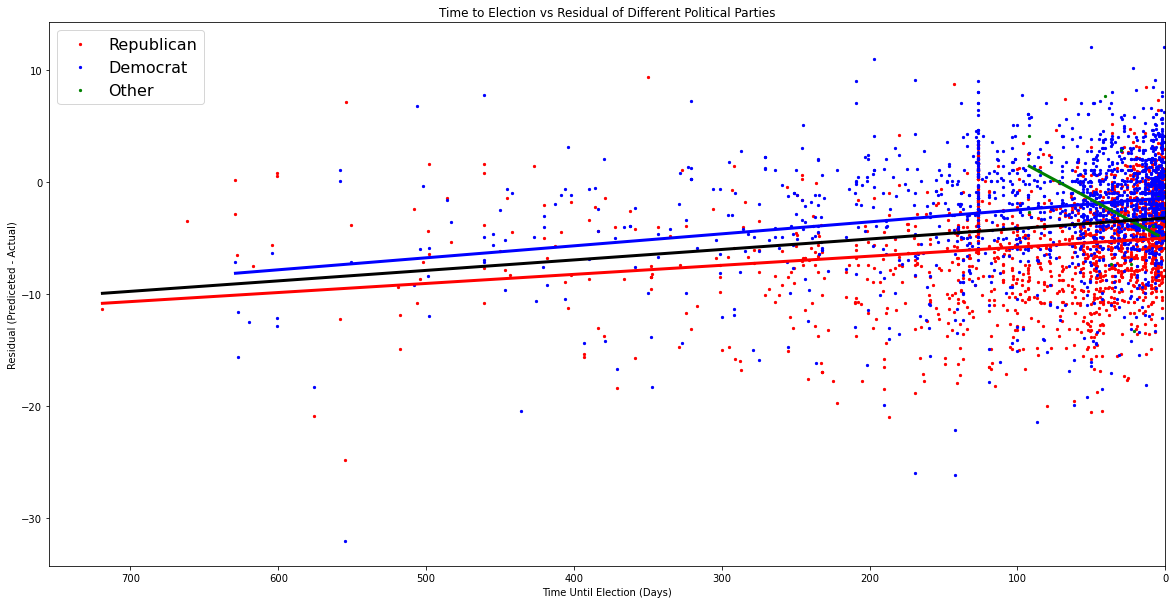

In [12]:
# split data up into 3 different tables
data_r = data[data['party'] == "REPUBLICAN"]
data_d = data[data['party'] == "DEMOCRAT"]
data_o = data[data['party'] == "OTHER"]

# set graph size
plt.figure(figsize = (20, 10))

# invert axis so start of election(0 Days until election) is at the end of the graph this way time moves from left to right
plt.gca().invert_xaxis()

# set title and labels
plt.title("Time to Election vs Residual of Different Political Parties")
plt.xlabel("Time Until Election (Days)")
plt.ylabel("Residual (Prediceted - Actual)")

# plot data
scatter(plt, data_r, 'until_election', 'residual', 'red', 'Republican')
scatter(plt, data_d, 'until_election', 'residual', 'blue', 'Democrat')
scatter(plt, data_o, 'until_election', 'residual', 'green', 'Other')

# add overall trend line
trend_line(plt, data, 'until_election', 'residual', 'black')

# add legend for context
plt.legend(loc="upper left", prop={'size': 16})

# lim x so plot ends at election day
plt.xlim(None, 0)

plt.show()

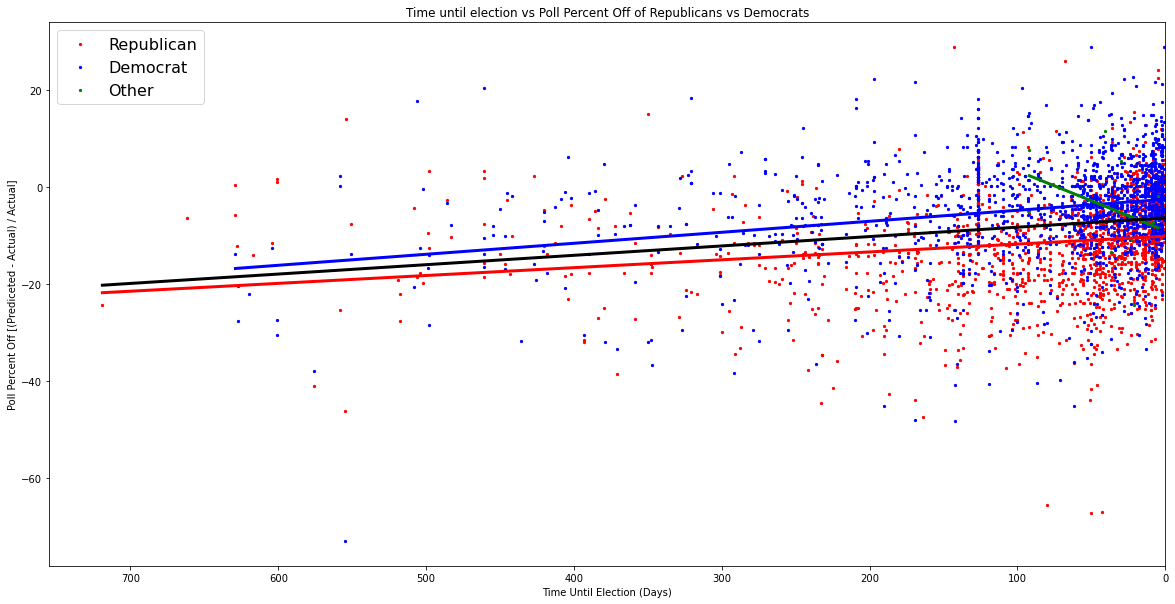

In [13]:
# set graph size
plt.figure(figsize = (20, 10))

# invert axis so start of election(0 Days until election) is at the end of the graph this way time moves from left to right
plt.gca().invert_xaxis()

# set title and labels
plt.title("Time until election vs Poll Percent Off of Republicans vs Democrats")
plt.xlabel("Time Until Election (Days)")
plt.ylabel("Poll Percent Off [(Prediceted - Actual) / Actual]")

# plot data
scatter(plt, data_r, 'until_election', 'percent_off', 'red', 'Republican')
scatter(plt, data_d, 'until_election', 'percent_off', 'blue', 'Democrat')
scatter(plt, data_o, 'until_election', 'percent_off', 'green', 'Other')

# add overall trend line
trend_line(plt, data, 'until_election', 'percent_off', 'black')

# lim x so plot ends at election day
plt.xlim(None, 0)

# add legend for context
plt.legend(loc="upper left", prop={'size': 16})

plt.show()

A potential reason for why polls seem to under predict is probably because most polls have not sure as an option and the farther away the election is, the higher percentage of people will not be informed and more likely to answer that they are not sure. This leads to a lower predicted percentage of votes compared to the actual value because those who have not made up their mind at the time of the polls will eventually contribute to one of the candidates' percentages.

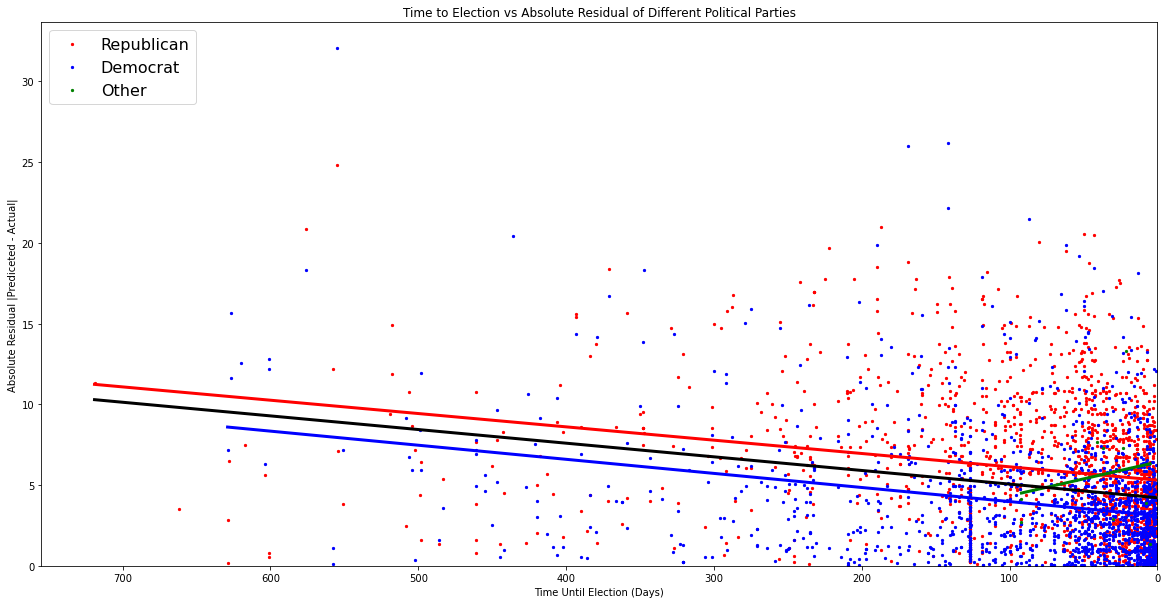

In [14]:
# set graph size
plt.figure(figsize = (20, 10))

# invert axis so start of election(0 Days until election) is at the end of the graph this way time moves from left to right
plt.gca().invert_xaxis()

# set title and labels
plt.title("Time to Election vs Absolute Residual of Different Political Parties")
plt.xlabel("Time Until Election (Days)")
plt.ylabel("Absolute Residual |Prediceted - Actual|")

# plot data
scatter(plt, data_r, 'until_election', 'abs_residual', 'red', 'Republican')
scatter(plt, data_d, 'until_election', 'abs_residual', 'blue', 'Democrat')
scatter(plt, data_o, 'until_election', 'abs_residual', 'green', 'Other')

# add overall trend line
trend_line(plt, data, 'until_election', 'abs_residual', 'black')

# add legend for context
plt.legend(loc="upper left", prop={'size': 16})

# lim x and y so plot x ends at election day y and starts at 0 which is the min possible error
plt.xlim(None, 0)
plt.ylim(0)

plt.show()

Since our data gets more accurate the closer we get to the election we will create a term that reflects the actual error compared to the expected error. The farther below the expected error the poll is the better the score. This term is called normalized residual. The higher the normalized residual the better the poll. 

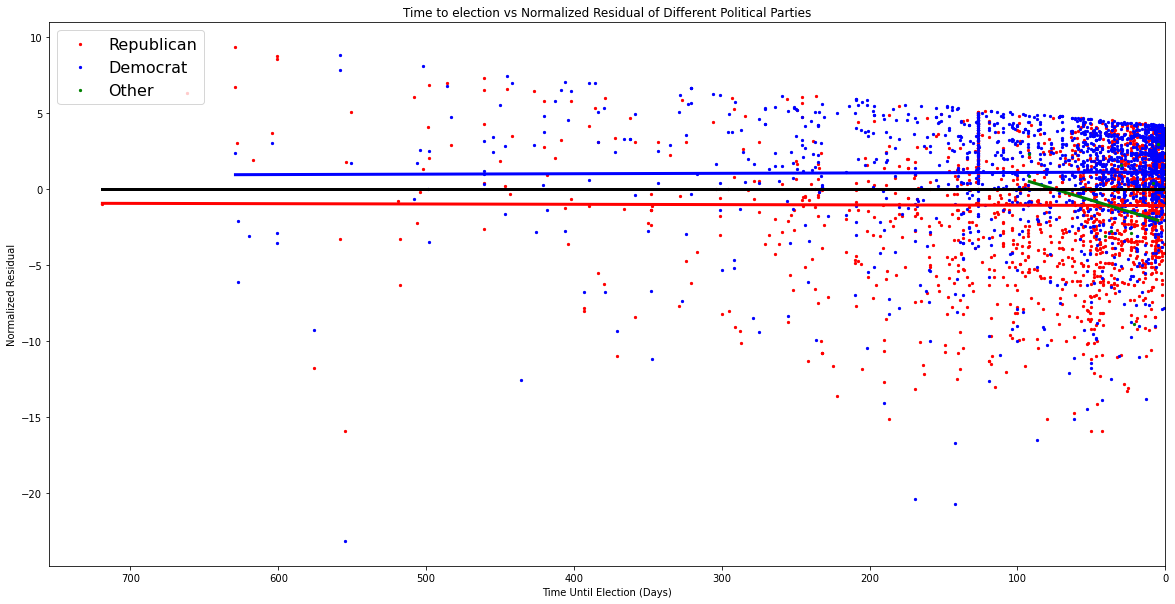

In [15]:
# set graph size
plt.figure(figsize = (20, 10))

# invert axis so start of election(0 Days until election) is at the end of the graph this way time moves from left to right
plt.gca().invert_xaxis()

# set title and labels
plt.title("Time to election vs Normalized Residual of Different Political Parties")
plt.xlabel("Time Until Election (Days)")
plt.ylabel("Normalized Residual")

# plot data
scatter(plt, data_r, 'until_election', 'norm_residual', 'red', 'Republican')
scatter(plt, data_d, 'until_election', 'norm_residual', 'blue', 'Democrat')
scatter(plt, data_o, 'until_election', 'norm_residual', 'green', 'Other')

# add overall trend line
trend_line(plt, data, 'until_election', 'norm_residual', 'black')

# lim x so plot ends at election day
plt.xlim(None, 0)

# add legend for context
plt.legend(loc="upper left", prop={'size': 16})

plt.show()

We notice there is a gap at the top, this is because a poll can only be perfectly accurate, the top represents the best possible guess. Guesses can only be so good but can be super wrong

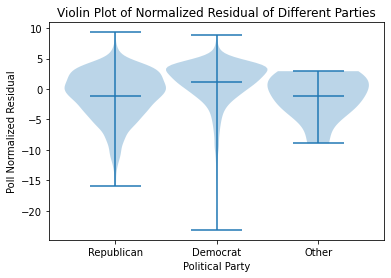

In [16]:
fig, ax = plt.subplots()

# break up into labels and data
labels = ["Republican", "Democrat", "Other"]
party_data = [data_r['norm_residual'], data_d['norm_residual'], data_o['norm_residual']]

# plot data
ax.violinplot(party_data, widths=1, showmeans=True)

# set labels
ax.set_title('Violin Plot of Normalized Residual of Different Parties')
ax.set_ylabel('Poll Normalized Residual')
ax.set_xlabel('Political Party')

ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

A two sample T-Test will now be conducted to determine whether or not there is a significant difference between the polling data for Democrat vs Republican candidates. For this test we will make the assumption that both samples are normally distributed. Examining the graph both data sets do appear to be close to normally distributed. Furthermore we have far more than 30 samples so we can approximate a normal distribution anyways. We also know that the dependent variable is measured on the interval scale, in this case that's because both the percentages (predicted and actual) are on an interval scale so their difference will be as well. Furthermore we make the assumption that combined, these surveys make up an accurate sample of the general population. We do need to be careful because averaging these surveys does represent taking an average of averages, however the values that are being averaged are constrained to the interval 0-100.  

The null hypothesis is that there is no difference between samples and that a poll of a Democrat candidate will be just as accurate of that of a Republican candidate. The alternative hypothesis is that there is a significant difference between the two parties when it comes to the accuracy of the polls to find their percentage of votes received.

These values represent just a subset of all polls which in turn is attempting to represent the voting population as a whole. For this reason we will examine the variance of both groups to ensure they do not differ too much. If they do differ too much we would not be able to use a two sample t-test.

Our cutoff value for significance will be .05. Anything less than .05 and we will reject the null and accept the alternative hypothesis.

More about 2 sample t-tests https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [17]:
print(np.var(data_r['norm_residual']), np.var(data_d['norm_residual']))


15.866414553027488 12.13155187272518


Our residuals are reasonably close so we can make the assumption that both samples have equal variance. Thus, we can continue with the test.

In [18]:
stats.ttest_ind(a=data_r['norm_residual'], b=data_d['norm_residual'], equal_var=True)

Ttest_indResult(statistic=-16.854721615743554, pvalue=2.758972855580445e-61)

We got a p-value of 2.758972855580445e-61 which is well below the .05 threshold for significance. Thus we can reject the null hypothesis and conclude that there is a significant difference between the two parties when it comes to the accuracy of the polls to find their percentage of votes received. This is not a surprising result, it is well known that Republicans tend to receive more votes in the actual election compared to polling data. This phenomenon is not entirely understood but some hypotheses that this may occur because Republican voters are generally more enthusiastic than Democrat voters and the more enthusiastic the voter the more likely they are to vote. More information about this can be read about here https://www.cnn.com/2022/02/19/politics/enthusiasm-republican-midterms-high/index.html and https://www.politico.com/news/2021/07/18/pollsters-2020-polls-all-wrong-500050

Analysis by Pollster

We will now examine to see if the quality of the data from the poll is dependent on some of the availabel data about the pollster collecting the data. 

Comparing partisan pollsters vs non partisan pollsters

The first thing we will examine is if the pollster being partisan has a noticable effect on the data.

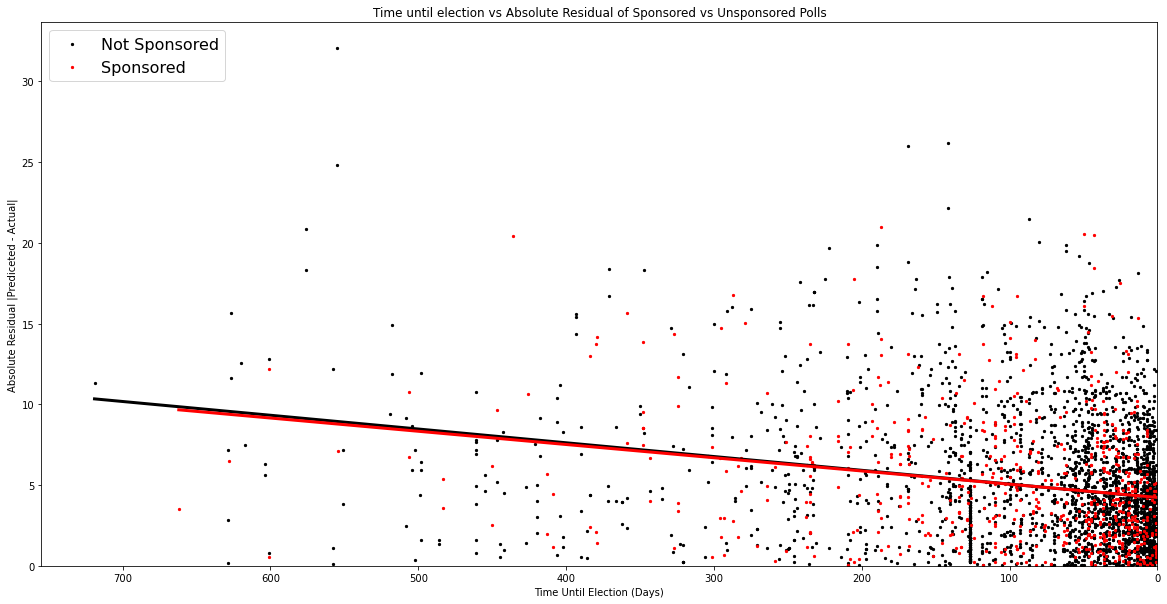

In [19]:
# break up data into partisan and not partisan
pollster_sponsored = data[~data['partisan'].isna()]
pollster_not_sponsored = data[data['partisan'].isna()]

# set graph size
plt.figure(figsize = (20, 10))

# invert axis so start of election(0 Days until election) is at the end of the graph this way time moves from left to right
plt.gca().invert_xaxis()

# set title and labels
plt.title("Time until election vs Absolute Residual of Sponsored vs Unsponsored Polls")
plt.xlabel("Time Until Election (Days)")
plt.ylabel("Absolute Residual |Prediceted - Actual|")

# plot the data
scatter(plt, pollster_not_sponsored, 'until_election', 'abs_residual', 'black', 'Not Sponsored')
scatter(plt, pollster_sponsored, 'until_election', 'abs_residual', 'red', 'Sponsored')

# add legend for context
plt.legend(loc="upper left", prop={'size': 16})

# lim x and y so plot x ends at election day y and starts at 0 which is the min possible error
plt.ylim(0)
plt.xlim(None, 0)

plt.show()

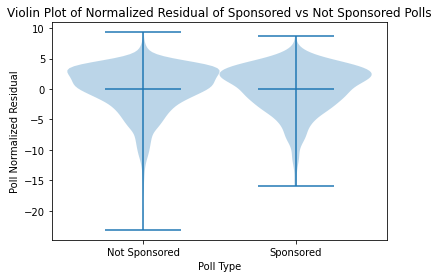

In [20]:
fig, ax = plt.subplots()

# break up into labels and data
labels = ["Not Sponsored", "Sponsored"]
party_data = [pollster_not_sponsored['norm_residual'], pollster_sponsored['norm_residual']]

# plot data
ax.violinplot(party_data, widths=1, showmeans=True)

# set labels
ax.set_title('Violin Plot of Normalized Residual of Sponsored vs Not Sponsored Polls')
ax.set_ylabel('Poll Normalized Residual')
ax.set_xlabel('Poll Type')

# set labels
ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

By Pollster Rating

FiveThirtyEight provides a pollster grade for each pollster that is "Based on the historical accuracy and methodology of each polling organization’s polls". The rating is also “adjusted for the type of election polled, the poll’s sample size, the performance of other polls surveying the same race and other factors". I decided to just break the data up into general categories of A, B, and C because it will be easier to visualize the group and each individual rating is less likely to be influenced by one good/bad pollster. Furthermore if there is a significant difference between the different letter ratings I can check to see how much of a correlation there is between the individual modifiers ie +/-.

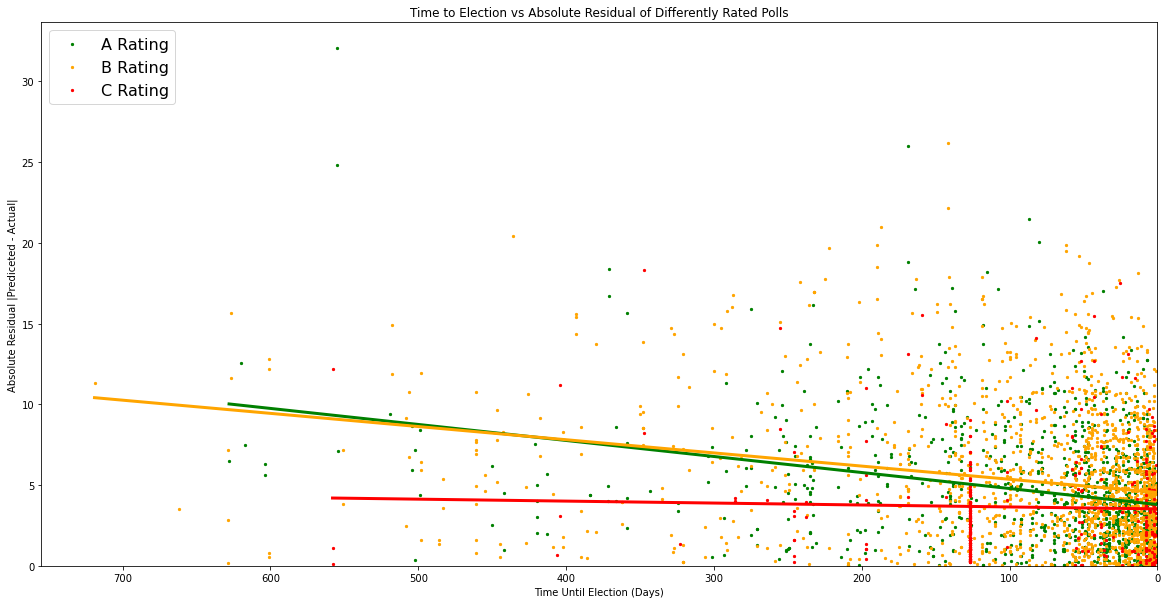

In [21]:
# break up data by rating
data_a = data[data['fte_grade'].isin(['A+', 'A', 'A-', 'A/B'])]
data_b = data[data['fte_grade'].isin(['B+', 'B', 'B-', 'B/C'])]
data_c = data[data['fte_grade'].isin(['C+', 'C', 'C-', 'C/D'])]

# set graph size
plt.figure(figsize = (20, 10))

# invert axis so start of election(0 Days until election) is at the end of the graph this way time moves from left to right
plt.gca().invert_xaxis()

# set title and labels
plt.title("Time to Election vs Absolute Residual of Differently Rated Polls")
plt.xlabel("Time Until Election (Days)")
plt.ylabel("Absolute Residual |Prediceted - Actual|")

# plot data
scatter(plt, data_a, 'until_election', 'abs_residual', 'green', 'A Rating')
scatter(plt, data_b, 'until_election', 'abs_residual', 'orange', 'B Rating')
scatter(plt, data_c, 'until_election', 'abs_residual', 'red', 'C Rating')

# add legend for context
plt.legend(loc="upper left", prop={'size': 16})

# lim x and y so plot x ends at election day y and starts at 0 which is the min possible error
plt.ylim(0)
plt.xlim(None, 0)

plt.show()

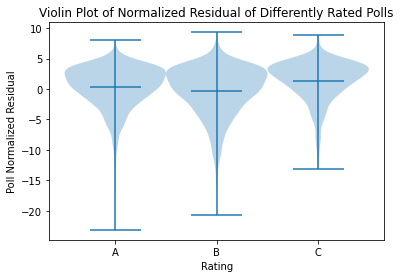

In [22]:
fig, ax = plt.subplots()

# break up into labels and data
labels = ["A", "B", "C"]
party_data = [data_a['norm_residual'], data_b['norm_residual'], data_c['norm_residual']]

# plot data
ax.violinplot(party_data, widths=1, showmeans=True)

# set labels
ax.set_title('Violin Plot of Normalized Residual of Differently Rated Polls')
ax.set_ylabel('Poll Normalized Residual')
ax.set_xlabel('Rating')

ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

Strange that the C rating polls are seemingly more accurate. Lets look into that more.

In [23]:
print(len(data_c.index))
print(len(data_c['pollster'].unique()))

# get number of polls performed by each C rated pollster
data_c_pollsters = data_c.groupby('pollster')['pollster_rating_id'].count()
data_c_pollsters.sort_values(key=lambda x: x, ascending=False, inplace=True)
data_c_pollsters.head(3)

350
14


pollster
SurveyMonkey    175
SSRS             68
Swayable         40
Name: pollster_rating_id, dtype: int64

In [24]:
print(data[data['pollster'] == "SurveyMonkey"]["abs_residual"].mean())
print(data[data['pollster'] == "SSRS"]["abs_residual"].mean())
print(data[data['pollster'] == "Swayable"]["abs_residual"].mean())
print(data["abs_residual"].mean())

2.8757142857142854
4.152499999999998
3.7262500000000003
4.908809245172558


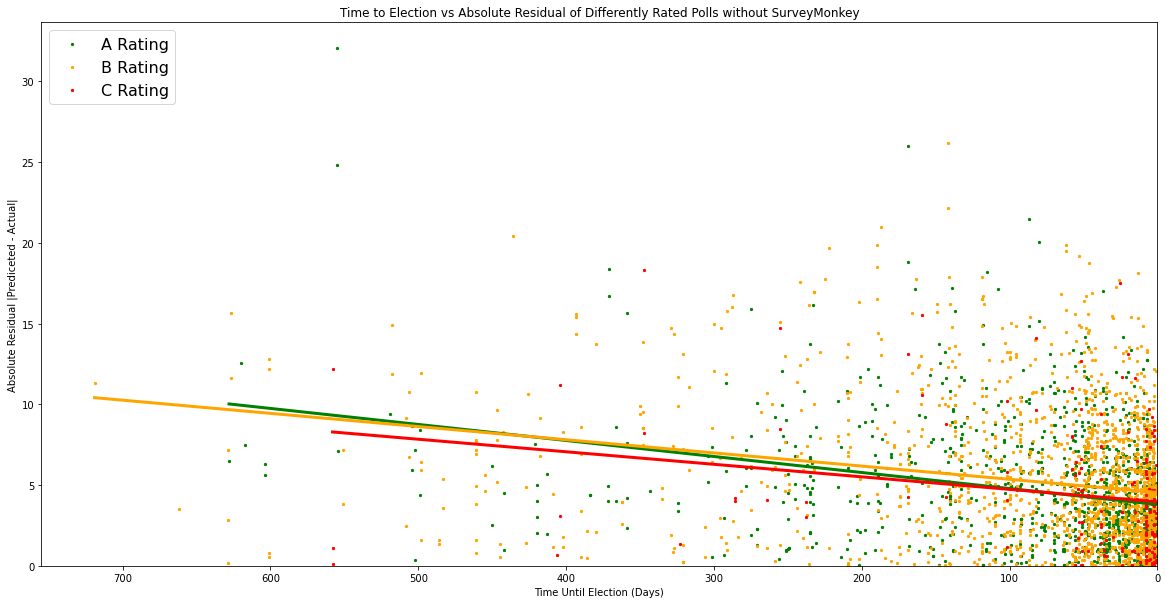

In [25]:
# remove surveyMonkey from the c results
data_c_wout = data_c[data_c['pollster'] != "SurveyMonkey"]

# set graph size
plt.figure(figsize = (20, 10))

# invert axis so start of election(0 Days until election) is at the end of the graph this way time moves from left to right
plt.gca().invert_xaxis()

# set title and labels
plt.title("Time to Election vs Absolute Residual of Differently Rated Polls without SurveyMonkey")
plt.xlabel("Time Until Election (Days)")
plt.ylabel("Absolute Residual |Prediceted - Actual|")

# plot the data
scatter(plt, data_a, 'until_election', 'abs_residual', 'green', 'A Rating')
scatter(plt, data_b, 'until_election', 'abs_residual', 'orange', 'B Rating')
scatter(plt, data_c_wout, 'until_election', 'abs_residual', 'red', 'C Rating')

# add legend for context
plt.legend(loc="upper left", prop={'size': 16})

# lim x and y so plot x ends at election day y and starts at 0 which is the min possible error
plt.ylim(0)
plt.xlim(None, 0)

plt.show()

By Survey Type

Now we will examine the different survey methods used by pollsters to see if there is a distinguishable difference in accuracy between the different methods

In [26]:
print(data['methodology'].unique())
# IVR is interactive voice response polling
print(len(data[data['methodology'] == "IVR"]))
print(len(data[data['methodology'] == "Online"]))
print(len(data[data['methodology'] == "Live Phone"]))
print(len(data[data['methodology'] == "Mail"]))
print(len(data[data['methodology'] == "Text"]))

['Live Phone/Online' 'IVR/Online/Text' 'IVR/Live Phone' 'Live Phone'
 'Online' 'IVR/Online' 'Live Phone/Text' 'IVR' 'Online/Text' 'IVR/Text'
 nan 'IVR/Live Phone/Text' 'Text' 'Mail' 'Live Phone/Online/Text'
 'IVR/Live Phone/Online']
126
1042
1147
6
12


In [27]:
method_data = data[data['methodology'].notna()]
method_online = method_data[method_data['methodology'] == "Online"]
method_phone = method_data[method_data['methodology'] == "Live Phone"]
method_other =  method_data[(method_data['methodology'] != "Live Phone") & (method_data['methodology'] != "Online")]

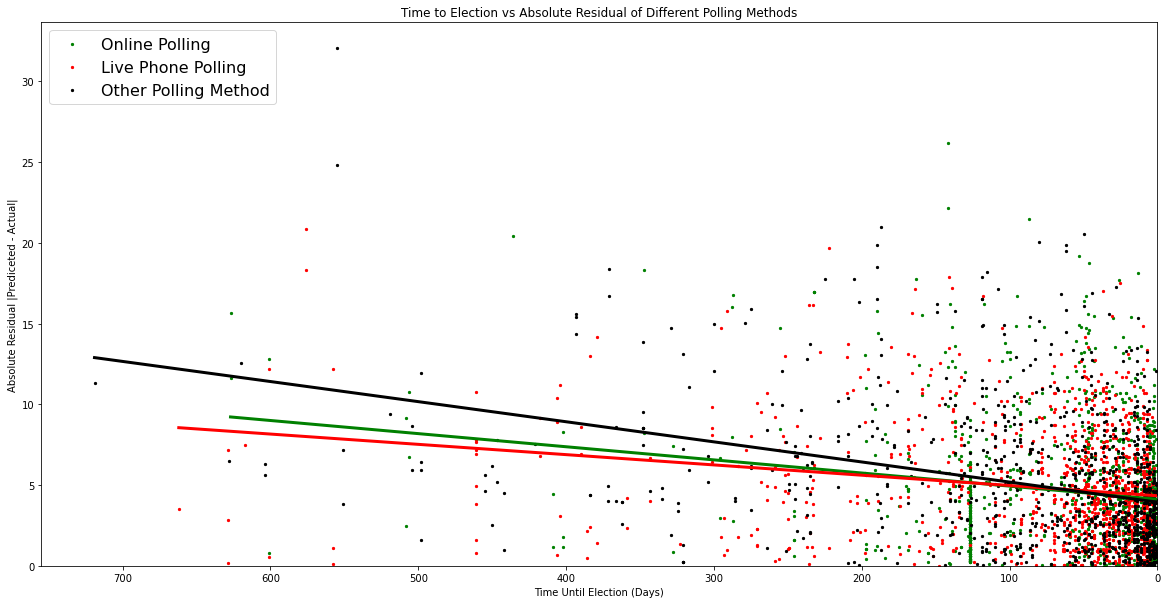

In [28]:
# set graph size
plt.figure(figsize = (20, 10))

# invert axis so start of election(0 Days until election) is at the end of the graph this way time moves from left to right
plt.gca().invert_xaxis()

# set title and labels
plt.title("Time to Election vs Absolute Residual of Different Polling Methods")
plt.xlabel("Time Until Election (Days)")
plt.ylabel("Absolute Residual |Prediceted - Actual|")

# plot data
scatter(plt, method_online, 'until_election', 'abs_residual', 'green', 'Online Polling')
scatter(plt, method_phone, 'until_election', 'abs_residual', 'red', 'Live Phone Polling')
scatter(plt, method_other, 'until_election', 'abs_residual', 'black', 'Other Polling Method')

# add legend for context
plt.legend(loc="upper left", prop={'size': 16})

# lim x and y so plot x ends at election day y and starts at 0 which is the min possible error
plt.ylim(0)
plt.xlim(None, 0)

plt.show()

Sample Size

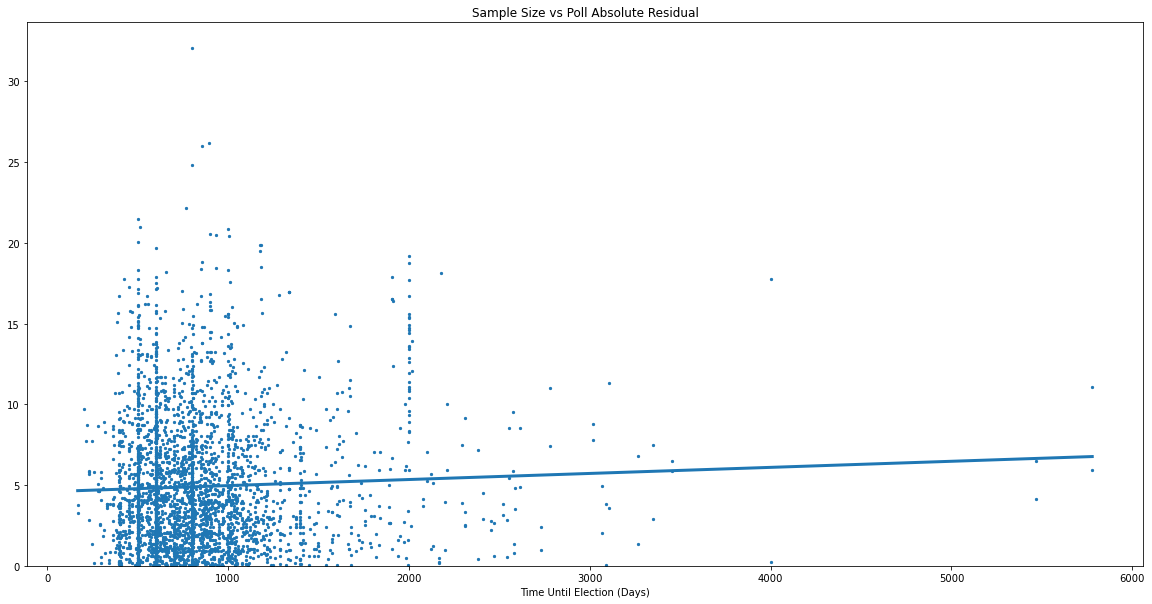

In [29]:
# get just data with a listed sample size
data_sample_size = data[~data['sample_size'].isna()]

# set graph size
plt.figure(figsize = (20, 10))

# set title and labels
plt.title("Sample Size vs Poll Absolute Residual")
plt.xlabel("Sample Size")
plt.xlabel("Time Until Election (Days)")

# plot data
scatter(plt, data_sample_size, 'sample_size', 'abs_residual')

# lim y so bottom of plot rests on 0 which is min residual
plt.ylim(0)

plt.show()

Could potentially be that polls with larger sample sizes are not doing their due dilligance to get truly random samples which is compromising their results. Its also possible that its just a coincidence.

based on stage

In [30]:
data['stage'].unique()

array(['RUNOFF', 'GENERAL'], dtype=object)

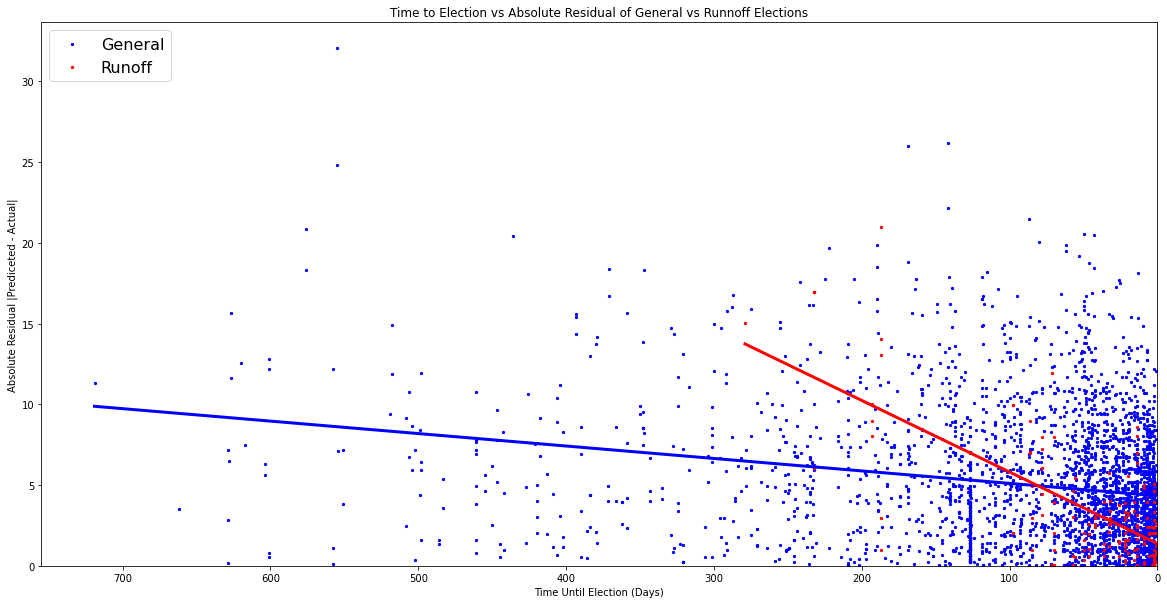

In [31]:
data_general = data[data['stage'] == "GENERAL"]
data_runoff = data[data['stage'] == "RUNOFF"]

# set graph size
plt.figure(figsize = (20, 10))

# invert axis so start of election(0 Days until election) is at the end of the graph this way time moves from left to right
plt.gca().invert_xaxis()

# set title and labels
plt.title("Time to Election vs Absolute Residual of General vs Runnoff Elections")
plt.xlabel("Time Until Election (Days)")
plt.ylabel("Absolute Residual |Prediceted - Actual|")

# plot data
scatter(plt, data_general, 'until_election', 'abs_residual', "blue", "General")
scatter(plt, data_runoff, 'until_election', 'abs_residual', "red", "Runoff")

# add legend for context
plt.legend(loc="upper left", prop={'size': 16})

# lim x and y so plot x ends at election day y and starts at 0 which is the min possible error
plt.ylim(0)
plt.xlim(None, 0)

plt.show()

Makes sense that runnoffs have shorter time frame, which is why there arnt polls for further out. Runnoffs do seem to have less error when it comes to the day of the election. However it dosent make sense that runnoffs would just have more accurate polls. It may be that more contested races (Races where candiates get close to 50% of the vote), are easier to get more accurate polling.

Accuracy by prediction percent

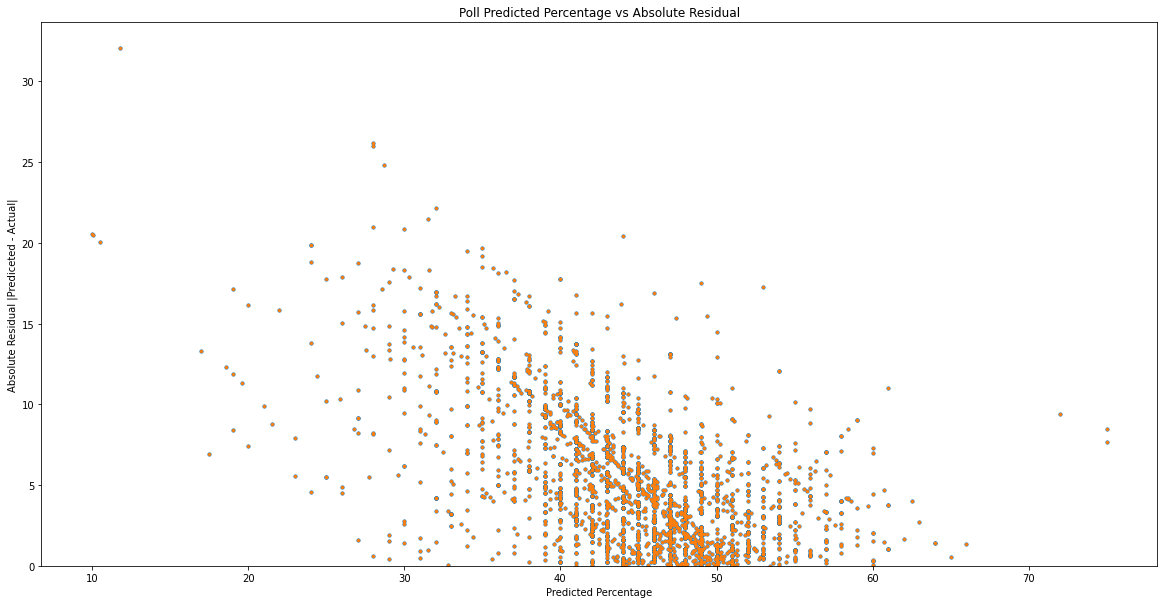

In [35]:
# set graph size
plt.figure(figsize = (20, 10))

# set title and labels
plt.title("Poll Predicted Percentage vs Absolute Residual")
plt.xlabel("Predicted Percentage")
plt.ylabel("Absolute Residual |Prediceted - Actual|")

# plot data
plt.scatter(data['pct'], data['abs_residual'], 10)

# plot data
scatter(plt, data, 'pct', 'abs_residual', best_fit=False)

plt.ylim(0)

plt.show()

Definentally appears to be a correlation here

In [33]:
data['pct_from_50'] = abs(50 - data['pct'])

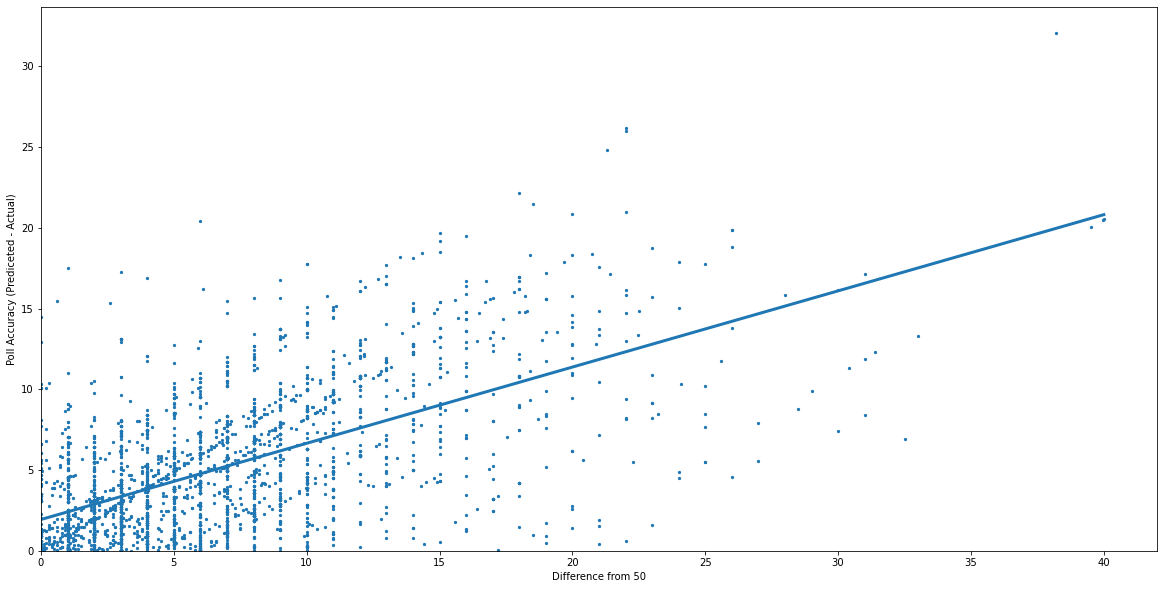

In [34]:
# set graph size
plt.figure(figsize = (20, 10))

# set title and labels
# plt.title("Time until election vs Poll Accuracy of Republicans vs Democrats")
plt.xlabel("Difference from 50")
plt.ylabel("Poll Accuracy (Prediceted - Actual)")

# plot data
scatter(plt, data, 'pct_from_50', 'abs_residual')

plt.ylim(0)
plt.xlim(0)

plt.show()

You can see the polls that rounded to the nearest integer when giving their estimate

4. Conclusion

The conclusion